In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

Populating the interactive namespace from numpy and matplotlib


In [2]:
datadir = '/home/mcoving/github/sinkhole_analysis/'
basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/'
hu10 = gpd.read_file(basedir+'USGS-NHD-DEMs/GDB/NHDPLUS_H_0511_HU4_GDB.gdb', layer='WBDHU10')

In [3]:
#Load Little Barren River HUC10
lbr = hu10[hu10.HUC10 == '0511000106']
lbr.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
rasterdir = os.path.join(basedir,'USGS-NHD-DEMs/Rasters/HRNHDPlusRasters0511/')
rasterfile = 'elev_cm.tif'
img = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=lbr,
                              clipname='HUC-0511000106-')

In [5]:
imgsrc = rio.open(datadir+'HUC-0511000106-elev_cm.tif')

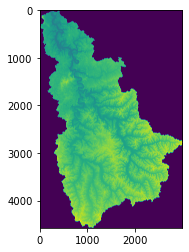

In [7]:
import rasterio.plot as riop 
riop.show(img)

In [31]:
sinks = clip_shp_to_geometry(clipname='HUC-0511000106-sinks-', 
                             shpdir=os.path.join(basedir, 'Kentucky','kysinks'),
                             shpfile='kentucky_sinkholes.shp',
                             geom_df=lbr,
                             outcrs=imgsrc.crs
                             )

In [32]:
sinks.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
sinksfile = os.path.join(datadir,'HUC-0511000106-sinks-kentucky_sinkholes.shp')
wat = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0511000106-elev_cm.tif',
                          sinksfile=sinksfile)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm-smoothed.tif' --filterx=5 --filtery=5

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating integral images: 19%
Creating integral images: 

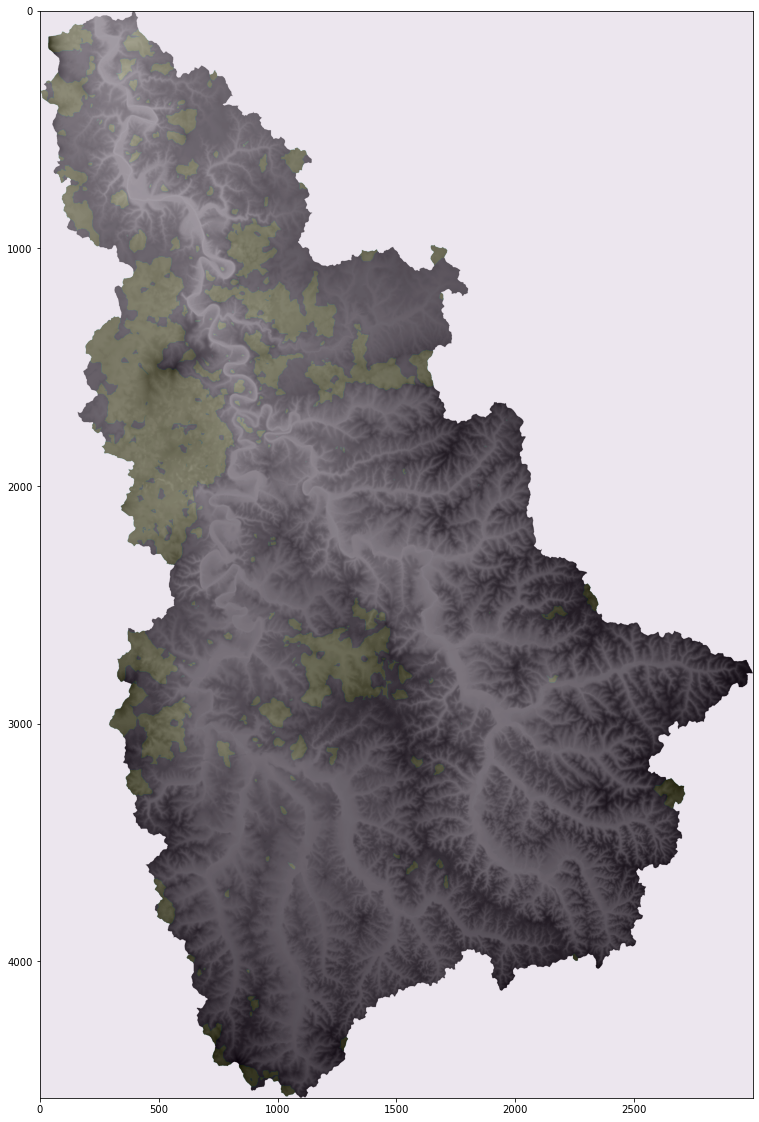

In [45]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)

Rasterizing using rasterio rather than whitebox

In [50]:
huc_sinks = gpd.read_file(datadir+'HUC-0511000106-sinks-kentucky_sinkholes.shp')
huc_sinks['ID'] = huc_sinks.index.values
huc_sinks

,ACRES,HECTARES,geometry,ID
0,1.893,0.766,"POLYGON ((928903.995 1597886.954, 928959.642 1...",0
1,2.394,0.969,"POLYGON ((928854.419 1598147.274, 928876.589 1...",1
2,2.597,1.051,"POLYGON ((928681.210 1597996.394, 928724.455 1...",2
3,8.983,3.636,"POLYGON ((929005.534 1598331.162, 929015.663 1...",3
4,10.040,4.063,"POLYGON ((928612.493 1598709.474, 928630.807 1...",4
...,...,...,...,...
1181,0.956,0.387,"POLYGON ((910664.361 1620259.576, 910682.522 1...",1181
1182,7.608,3.079,"POLYGON ((910558.868 1621309.267, 910559.572 1...",1182
1183,5.593,2.263,"POLYGON ((912590.271 1601812.196, 912586.457 1...",1183
1184,3.680,1.489,"POLYGON ((910079.759 1600534.964, 910099.645 1...",1184


In [81]:
sinks_list = huc_sinks[['geometry','ID']].values.tolist()

In [82]:
out_shape = imgsrc.shape
out_trans = imgsrc.transform
sinks_array = rasterio.features.rasterize(sinks_list,
                fill=0, out_shape= out_shape,
                transform = out_trans)

In [84]:
profile = imgsrc.profile
profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2999, 'height': 4574, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10.0, 0.0, 902365.0,
       0.0, -10.0, 1631345.0), 'tiled': False, 'interleave': 'band'}

In [86]:
with rasterio.open(datadir+'test_rasterize.tif', 'w', **profile) as dest:
    dest.write(sinks_array.astype(rasterio.int32), 1)

In [89]:
test_src = rasterio.open(datadir+'test_rasterize.tif')
test_img = test_src.read()

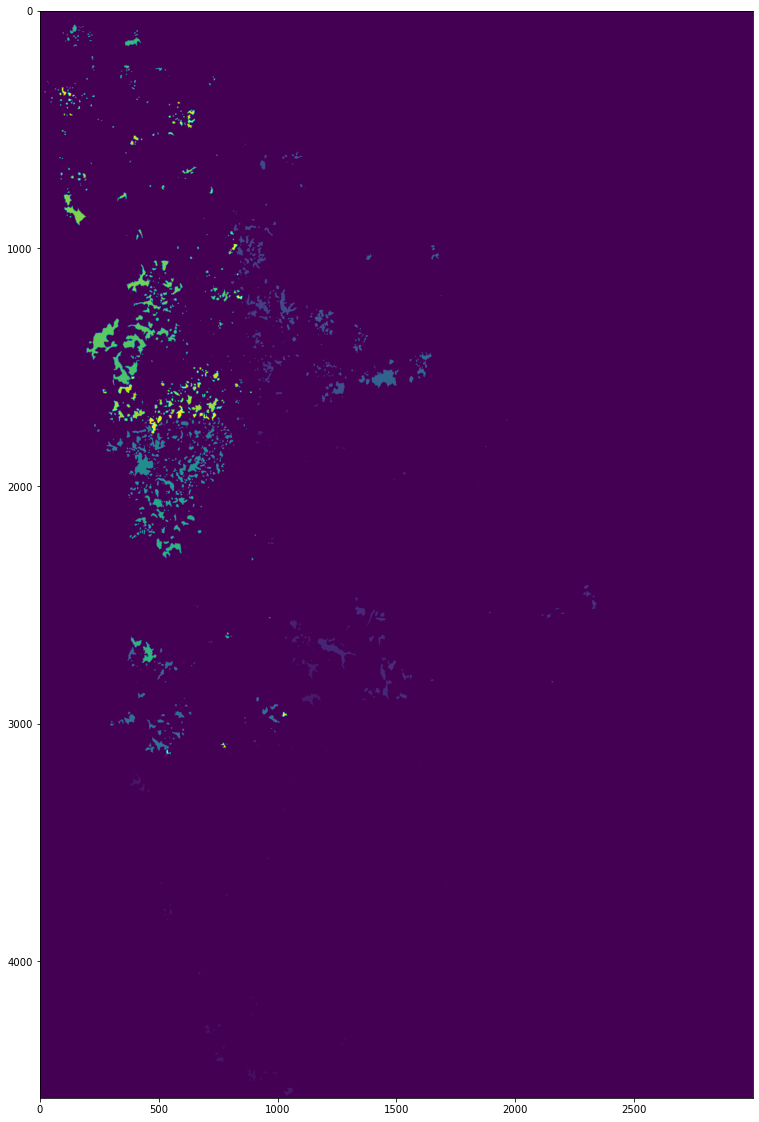

In [90]:
figure(figsize=(20,20))
riop.show(test_img)

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

<Figure size 1440x1440 with 0 Axes>

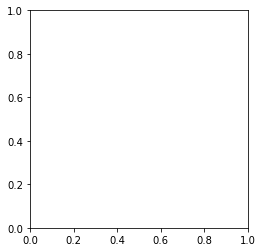

In [80]:
figure(figsize=(20,20))
huc_sinks.plot()

In [91]:
sinksfile = os.path.join(datadir,'test_rasterize.tif')
wat = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0511000106-elev_cm.tif',
                          sinksfile=sinksfile)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm-smoothed.tif' --filterx=5 --filtery=5

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating integral images: 19%
Creating integral images: 

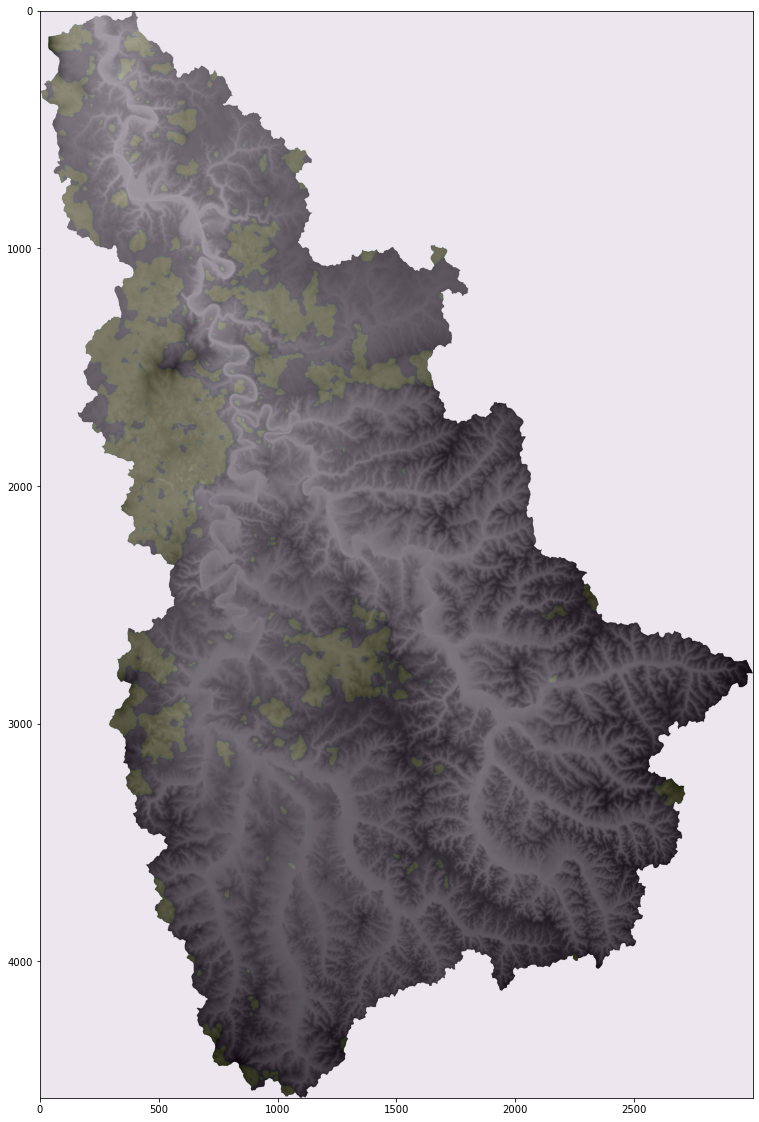

In [92]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)